In [2]:
import tqdm
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import ceil
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import rand_score
from matplotlib.patches import Ellipse

# Gaussian Mixture Model
A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.

Now we run GMM on each saved PCA model and save the results.

In [48]:
results = []

# load y labels
y = pd.read_feather(f'./data/mnist_subset_labels.feather').squeeze()

for i in tqdm.tqdm(range(2, 201)):
    # load PCA model and fit GMM
    X = pd.read_feather(f'./data/pca/mnist_pca_{i}.feather')
    
    out = {
        'PCA': i,
        'results': [],
    }
    
    for n_components in range(5, 16):
        hyper_params = {
            'n_components': n_components,
            'covariance_type': 'diag',
            'random_state': 42,
            'max_iter': 1000,
        }
        
        gmm = GaussianMixture(**hyper_params)
        
        start = time.time()
        gmm.fit(X)
        elapsed = time.time() - start
        
        start = time.time()
        clusters = gmm.predict(X)
        elapsed_pred = time.time() - start
        
        score = rand_score(y, clusters)
        
        out['results'].append({
            'n_components': gmm.n_components,
            'score': score,
            'fit_time': elapsed,
            'predict_time': elapsed_pred,
        })
        
    results.append(out)

100%|██████████| 199/199 [1:01:57<00:00, 18.68s/it]


Save the results to a feather file.

In [49]:
pd.DataFrame(results).to_feather('./results/gmm_results.feather')

# Results
The results are saved in a feather file. We can load them and make some statistics.

In [49]:
results = pd.read_feather('./results/gmm_results.feather')

## Best results
We can find the best results for each PCA dimension.

In [43]:
best_results = []
for i in range(len(results)):
    best = max(results.iloc[i]['results'], key=lambda x: x['score'])
    best_results.append({
        'PCA': results.iloc[i]['PCA'],
        'n_components': best['n_components'],
        'score': best['score'],
        'fit_time': best['fit_time'],
        'predict_time': best['predict_time'],
    })
    
best_results = pd.DataFrame(best_results)
best_results

,PCA,n_components,score,fit_time,predict_time
0,2,15,0.872736,0.394716,0.006903
1,3,15,0.869226,0.529290,0.004618
2,4,15,0.884630,0.433302,0.004798
3,5,15,0.883785,0.373983,0.004759
4,6,14,0.883986,0.570535,0.007494
...,...,...,...,...,...
194,196,15,0.809490,4.721830,0.038502
195,197,13,0.825137,3.786022,0.037492
196,198,13,0.825591,3.288878,0.037566
197,199,15,0.808395,5.821307,0.042275


## Best result overall

In [44]:
best_results.iloc[best_results['score'].idxmax()]

PCA             23.000000
n_components    15.000000
score            0.900229
fit_time         0.626646
predict_time     0.007704
Name: 21, dtype: float64

## Plots
Make a plot of the score in relation to the PCA dimension and one for the number of components in relation to the PCA dimension.

Text(0.5, 1.0, 'Number of components in relation to PCA dimension')

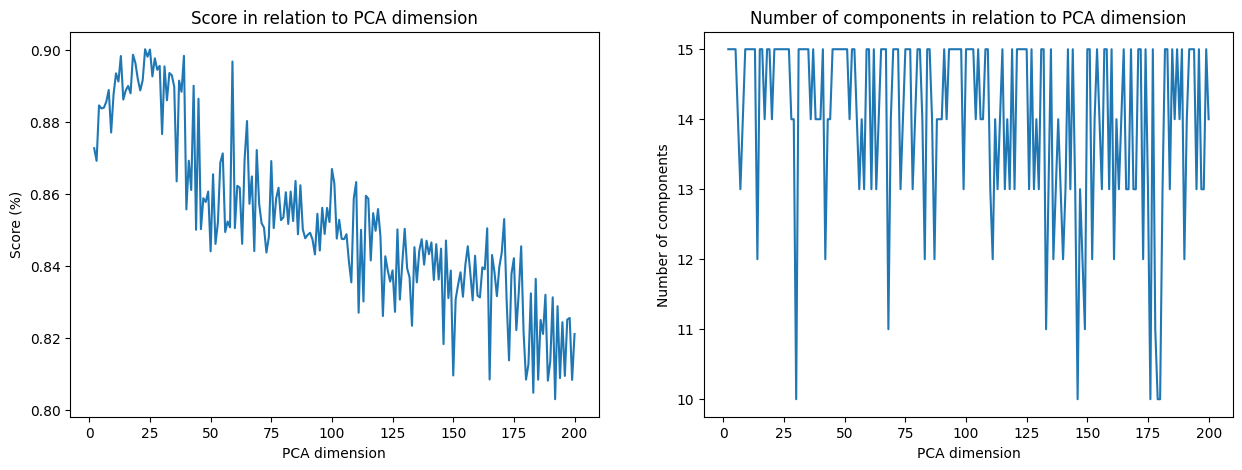

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(best_results['PCA'], best_results['score'])
ax[0].set_xlabel('PCA dimension')
ax[0].set_ylabel('Score (%)')
ax[0].set_title('Score in relation to PCA dimension')

ax[1].plot(best_results['PCA'], best_results['n_components'])
ax[1].set_ylabel('Number of components')
ax[1].set_xlabel('PCA dimension')
ax[1].set_title('Number of components in relation to PCA dimension')

Plot the fitting and prediction time in relation to the PCA dimension.

Text(0.5, 1.0, 'Prediction time in relation to PCA dimension')

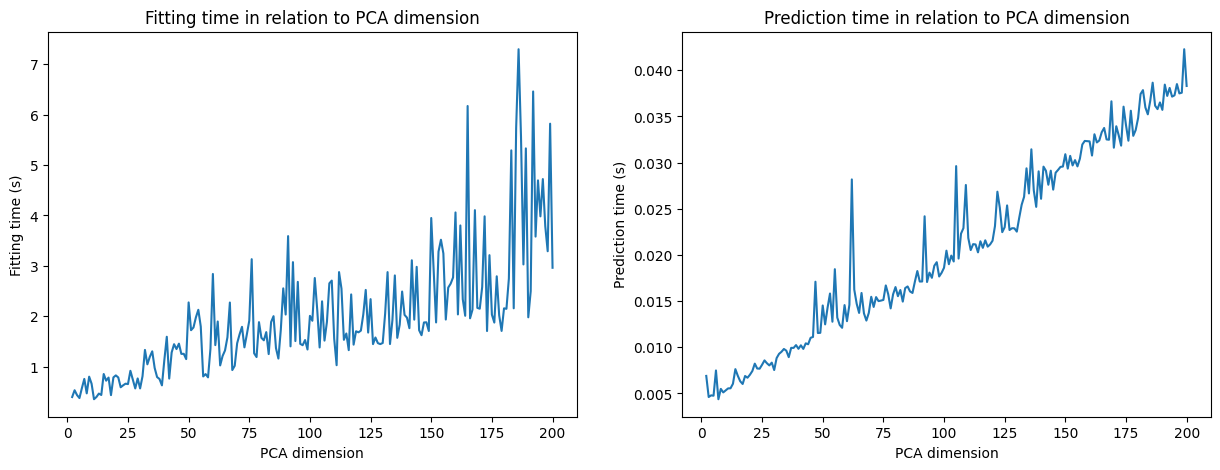

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(best_results['PCA'], best_results['fit_time'])
ax[0].set_xlabel('PCA dimension')
ax[0].set_ylabel('Fitting time (s)')
ax[0].set_title('Fitting time in relation to PCA dimension')

ax[1].plot(best_results['PCA'], best_results['predict_time'])
ax[1].set_xlabel('PCA dimension')
ax[1].set_ylabel('Prediction time (s)')
ax[1].set_title('Prediction time in relation to PCA dimension')

Plot the means of the Gaussian models visualized as a greyscale images after PCA reconstruction to inspect the learned model.

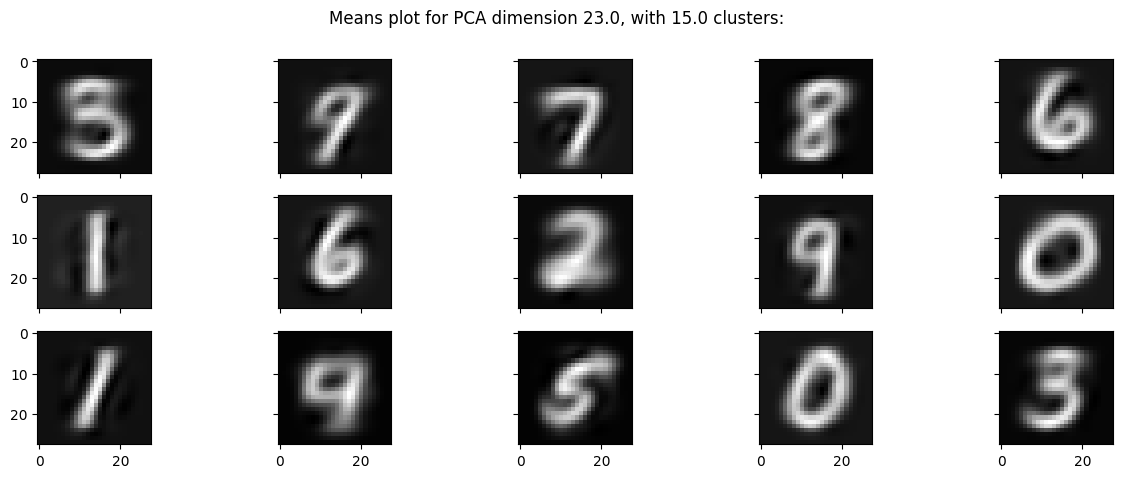

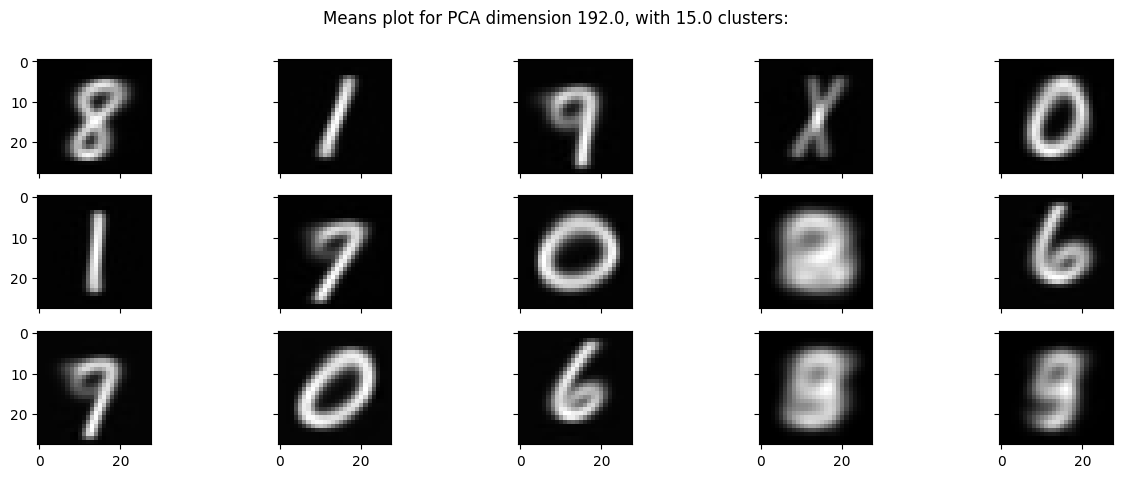

In [47]:
# get best and worst PCA models
best = best_results.iloc[best_results['score'].idxmax()]
worst = best_results.iloc[best_results['score'].idxmin()]

for model in [best, worst]:
    X = pd.read_feather('./data/pca/mnist_pca_' + str(int(model['PCA'])) + '.feather')
    with open('./models/pca/mnist_pca_' + str(int(model['PCA'])) + '.pkl', 'rb') as f:
        pca = pickle.load(f)
        
    gmm = GaussianMixture(n_components=int(model['n_components']), covariance_type='diag', random_state=42, max_iter=1000)
    gmm.fit(X)
    
    fig, ax = plt.subplots(ceil(model['n_components']/5), 5, figsize=(15, 5), sharex=True, sharey=True)
    axs = [item for sublist in ax for item in sublist]
    fig.suptitle(f"Means plot for PCA dimension {model['PCA']}, with {model['n_components']} clusters:")

    for j in range(int(best['n_components'])):
        axs[j].imshow(pca.inverse_transform(gmm.means_[j]).reshape(28, 28), cmap='gray')
        #axs[j].set_title(f'Component {j}')

Plotting cluster in 2 dimensions with Ellipses for the covariance.

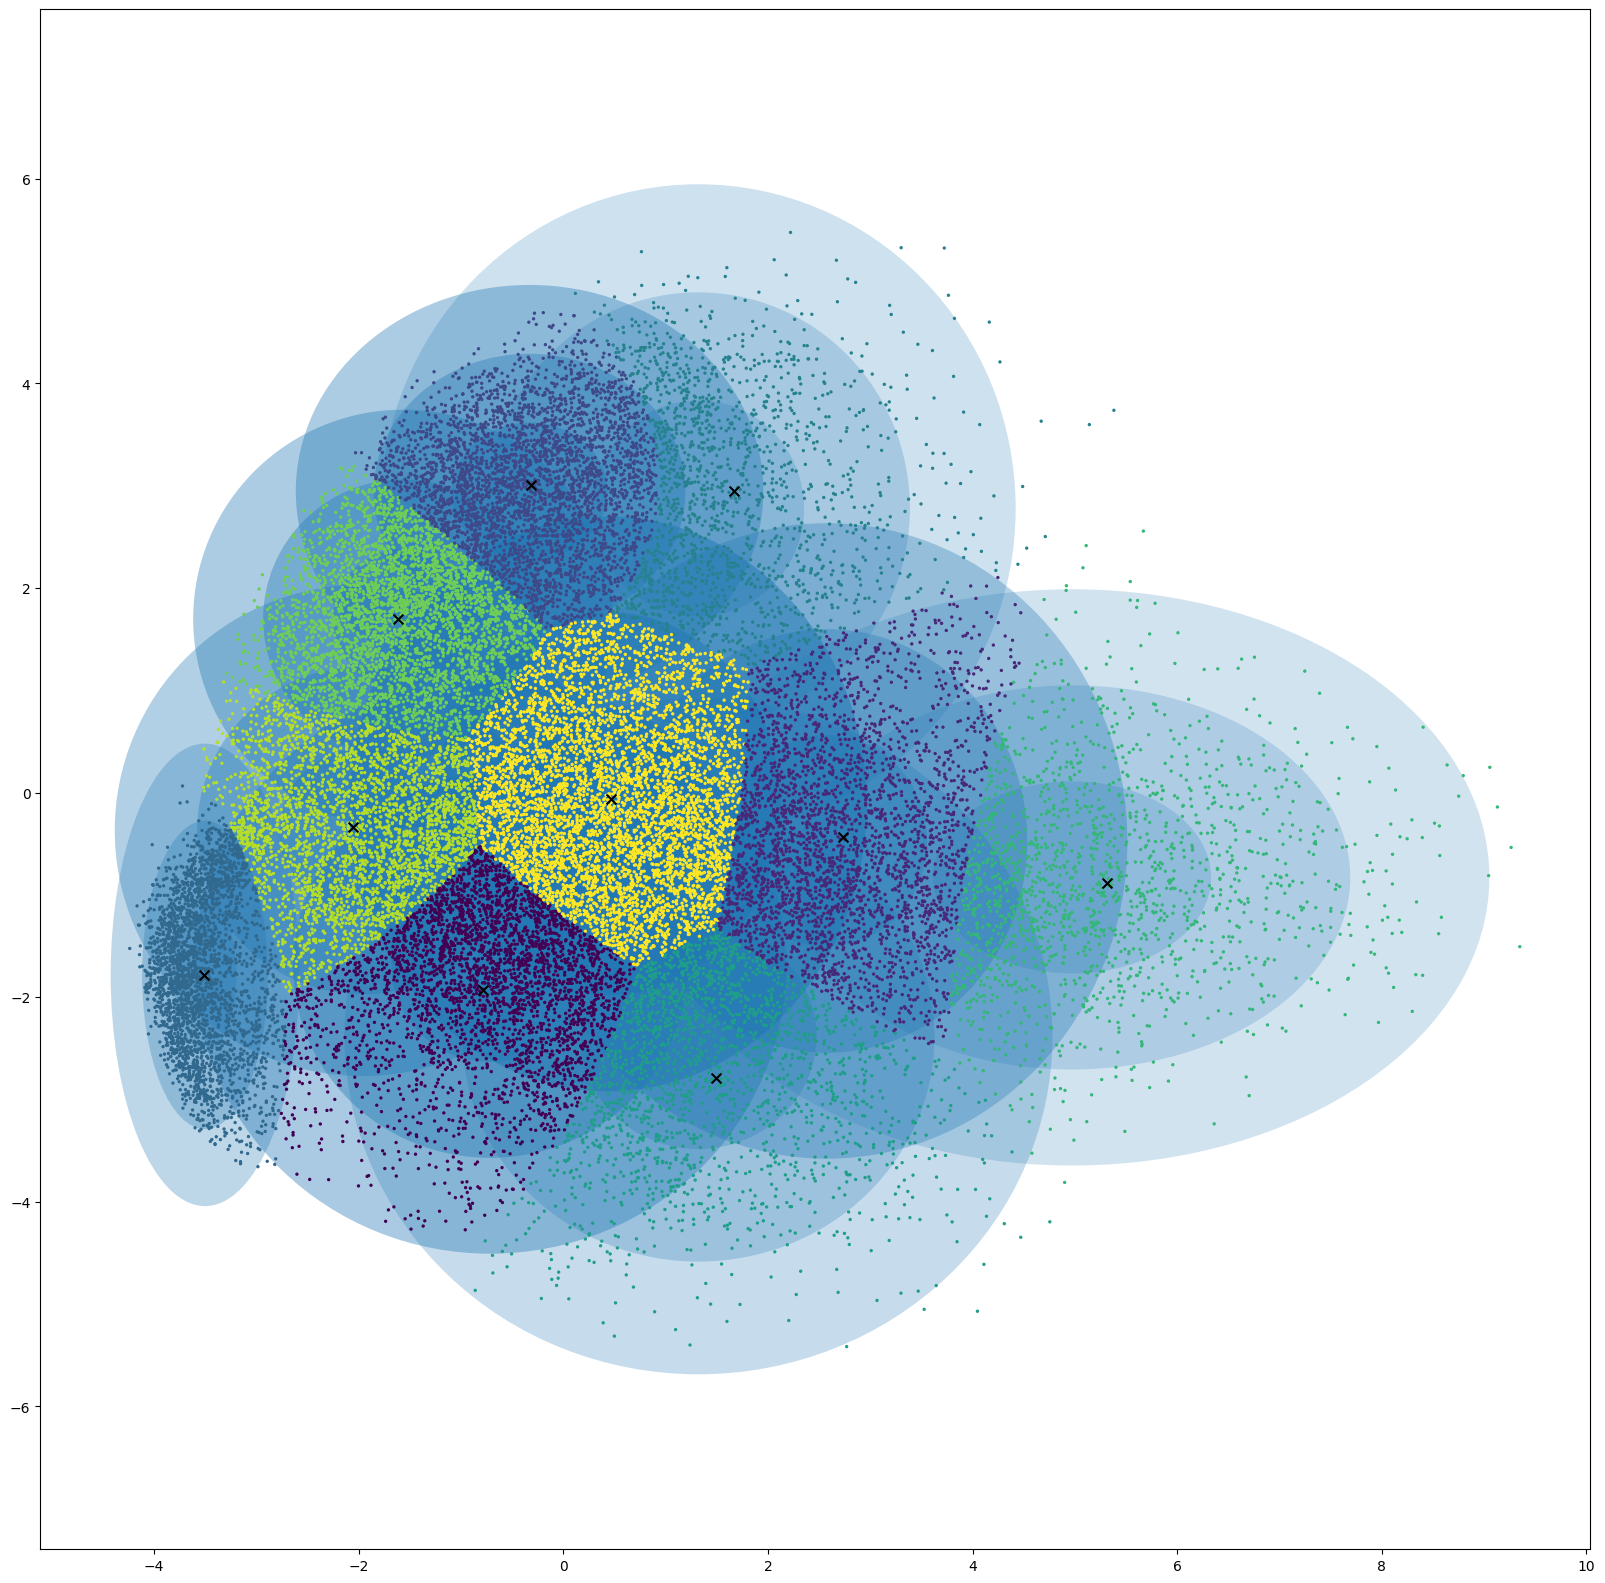

In [50]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height,
                             angle=angle, **kwargs))

def plot_gmm(gmm, X, ax=None):
    plt.figure(figsize=(20,20))
    plt.clf()
    ax = ax or plt.gca()    
        
    labels = gmm.fit(X).predict(X)
    cmap = plt.get_cmap('viridis')
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=2, cmap=cmap, zorder=2, alpha=1)
    ax.axis('equal')

    w_factor = 0.5 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        # color = cmap(0.8 * w * w_factor)
        draw_ellipse(pos, covar, ax = ax, alpha=w * w_factor)

    # draw cluster centers
    for cluster in np.unique(labels):
        center = X[labels == cluster].mean()
        ax.scatter(center[0], center[1], c='black', s=50, zorder=3, marker='x')

X = pd.read_feather('./data/pca/mnist_pca_2.feather')
gmm = GaussianMixture(n_components=10, covariance_type='diag', random_state=42, max_iter=1000)
plot_gmm(gmm, X)